In [1]:
import pandas as pd
import numpy as np

import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from dataHandler.preprocessor import Preprocessor
from sklearn import model_selection

__Accesing data__

In [2]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [3]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Splitting data__

In [4]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing data__

In [5]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [6]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

__Creating training sequences__

In [7]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 10
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

__Making pyTorch Dataset__

In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

/tmp/ipykernel_17716/1264527518.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xTrain = torch.Tensor(xTrain).to(device)


In [10]:
print(xTrain)

tensor([[[0.9597, 0.9695, 0.9684,  ..., 0.7717, 0.0000, 0.3090],
         [0.9781, 0.9702, 0.9684,  ..., 0.7717, 0.0000, 0.3090],
         [0.9740, 0.9696, 0.9756,  ..., 0.7717, 0.0000, 0.3104],
         ...,
         [0.9658, 0.9632, 0.9705,  ..., 0.9318, 0.0321, 0.3090],
         [0.9668, 0.9571, 0.9613,  ..., 0.9318, 0.0321, 0.2925],
         [0.9495, 0.9490, 0.9520,  ..., 0.9318, 0.0321, 0.2984]],

        [[0.9781, 0.9702, 0.9684,  ..., 0.7717, 0.0000, 0.3090],
         [0.9740, 0.9696, 0.9756,  ..., 0.7717, 0.0000, 0.3104],
         [0.9811, 0.9763, 0.9613,  ..., 0.7717, 0.0000, 0.2765],
         ...,
         [0.9668, 0.9571, 0.9613,  ..., 0.9318, 0.0321, 0.2925],
         [0.9495, 0.9490, 0.9520,  ..., 0.9318, 0.0321, 0.2984],
         [0.9444, 0.9410, 0.9481,  ..., 0.9318, 0.0321, 0.3059]],

        [[0.9740, 0.9696, 0.9756,  ..., 0.7717, 0.0000, 0.3104],
         [0.9811, 0.9763, 0.9613,  ..., 0.7717, 0.0000, 0.2765],
         [0.9546, 0.9652, 0.9625,  ..., 0.7717, 0.0000, 0.

In [11]:
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=4)

__Model__

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        num_of_filters = features*4
        #self.flatten = nn.Flatten()
        self.conv1 = nn.Conv1d(in_channels=features, out_channels=num_of_filters, kernel_size=1, padding = 'same', device = device)
        self.tanh = nn.Tanh()
        self.max_pool = nn.MaxPool1d(kernel_size=1)
        self.relu = nn.ReLU()
        self.l1 = nn.LSTM(input_size = num_of_filters, hidden_size = 128, num_layers = 1, bidirectional = False, device = device)
        self.dense = nn.Linear(128, 64, device = device)
        self.out = nn.Linear(64, samplesPredicted, device = device)

    def forward(self, x):
        #x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.max_pool(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x, _ = self.l1(x)
        x = self.tanh(x[:, -1, :])
        x = self.dense(x)
        x = self.tanh(x)
        out = self.out(x)
        return out

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv1d(11, 44, kernel_size=(1,), stride=(1,), padding=same)
  (tanh): Tanh()
  (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (l1): LSTM(44, 128)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [14]:
def trainLoop(epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for inputData, desired in loader:
            inputData = inputData.to(device)
            desired = desired.to(device)
            pred = model(inputData)
            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain.to(device))
            train_loss.append(loss_fn(y_pred, yTrain).cpu().numpy().tolist())
            y_pred = model(xTest.to(device))
            test_loss.append(loss_fn(y_pred, yTest).cpu().numpy().tolist())
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1:]}, Test Loss: {test_loss[-1:]}')
    return train_loss, test_loss


#model = torch.load('/content/model.pth')
train_loss, test_loss = trainLoop(65)
torch.save(model, 'model.pth')


Epoch [1/65], Train Loss: [0.09220772236585617], Test Loss: [0.07537949830293655]
Epoch [2/65], Train Loss: [0.038720134645700455], Test Loss: [0.1190166175365448]
Epoch [3/65], Train Loss: [0.03960377350449562], Test Loss: [0.10350639373064041]
Epoch [4/65], Train Loss: [0.020650537684559822], Test Loss: [0.05960774049162865]
Epoch [5/65], Train Loss: [0.006656792480498552], Test Loss: [0.02592920884490013]
Epoch [6/65], Train Loss: [0.003356819273903966], Test Loss: [0.008987599983811378]
Epoch [7/65], Train Loss: [0.01276342198252678], Test Loss: [0.010770037770271301]
Epoch [8/65], Train Loss: [0.0226887259632349], Test Loss: [0.018014805391430855]
Epoch [9/65], Train Loss: [0.02205914817750454], Test Loss: [0.018018029630184174]
Epoch [10/65], Train Loss: [0.016262797638773918], Test Loss: [0.013928938657045364]
Epoch [11/65], Train Loss: [0.010521847754716873], Test Loss: [0.009760971181094646]
Epoch [12/65], Train Loss: [0.006306993775069714], Test Loss: [0.006653336342424154]
E

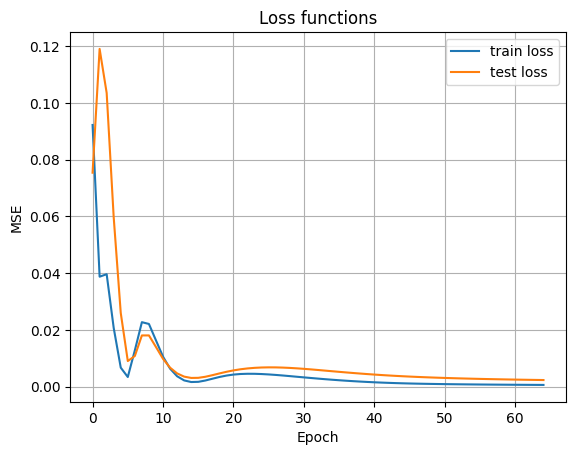

In [15]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(test_loss)
ax.legend(["train loss", "test loss"])
ax.grid()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("Loss functions")
plt.show()

__Testing__

Total Mean Squared Error: 0.0005681528127752244


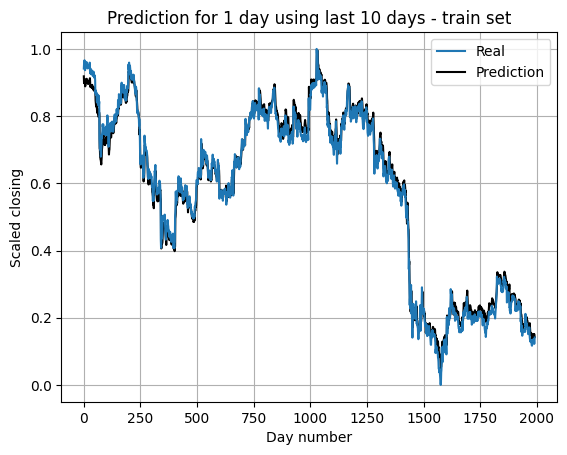

In [16]:
# Make predictions
y_pred = model(xTrain).cpu()

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTrain.cpu().detach().numpy()[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
#ax.plot(trainDates, real, zorder = 3)
#ax.plot(trainDates, predictions, color = 'black', zorder = 2)
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
#plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
#locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
#ax.xaxis.set_major_locator(locator)


ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



Total Mean Squared Error: 0.0022889128886163235


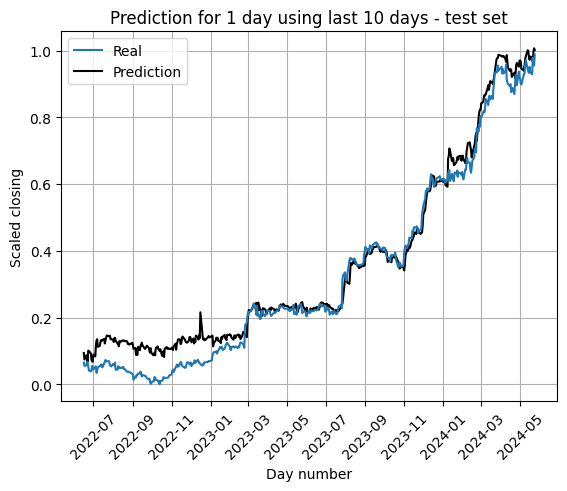

In [17]:
# Make predictions
y_pred = model(xTest).cpu()

y_pred = y_pred.detach().numpy()

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTest.cpu().detach().numpy()[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(np.array(testDates), real, zorder = 3)
ax.plot(np.array(testDates), predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()

